In [1]:
import numpy as np
import pandas as pd 
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

In [2]:
# you can select water_quality or water_potability
Dataset = 'water_potability'

In [3]:
def Load_Preprocess_WQ():
    # 水質資料集
    data = './dataset/waterQuality1.csv'
    df = pd.read_csv(data)
    
    # 刪除缺失值
    df.drop(df[df['is_safe'] == "#NUM!"].index, inplace=True)
    # 分割特徵與標籤
    X = df.drop(columns=['is_safe'])  # Features
    y = df['is_safe']  # Target
    #分割訓練集與測試集
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,shuffle=True)
    # 資料類型轉換 使用pd.to_numeric轉換成數字類型，
    y_train = pd.to_numeric(y_train, errors='coerce')
    y_test = pd.to_numeric(y_test, errors='coerce')
    X_train['ammonia'] = pd.to_numeric(X_train['ammonia'], errors='coerce')
    X_test['ammonia'] = pd.to_numeric(X_test['ammonia'], errors='coerce')
    # 設定特徵名稱
    
    feature_names = X.columns
    X_train = pd.DataFrame(X_train, columns=feature_names)
    X_test = pd.DataFrame(X_test, columns=feature_names) 
    return df, X_train, X_test, y_train, y_test


def Load_Preprocess_PT():
    # 水質資料集
    # 可飲用性資料集
    df = pd.read_csv("./dataset/water_potability.csv")
    
    # 以分群特徵平均值處理缺失值
    df['ph']=df['ph'].fillna(df.groupby(['Potability'])['ph'].transform('mean'))
    df['Sulfate']=df['Sulfate'].fillna(df.groupby(['Potability'])['Sulfate'].transform('mean'))
    df['Trihalomethanes']=df['Trihalomethanes'].fillna(df.groupby(['Potability'])['Trihalomethanes'].transform('mean'))
    
    # 將資料分成特徵(X)與標籤(y)
    # Potability為目標(y)欄位故從X中移除
    X = df.drop(["Potability"], axis=1).values
    y = df["Potability"]
    
    # 將資料分為訓練集 (70%)、驗證集和測試集 (30%)。
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
    
    # 標準化
    # StandardScaler 將每個特徵的均值設為 0，標準差設為 1，確保不同單位的特徵不會對模型造成不均衡的影響。
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # 定義特徵名稱
    feature_names = ['ph', 
                     'Hardness', 
                     'Solids', 
                     'Chloramines', 
                     'Sulfate', 
                     'Conductivity',
                     'Organic_carbon',  
                     'Trihalomethanes', 
                     'Turbidity']
    # 將資料給予特徵名稱
    
    X_train = pd.DataFrame(X_train, columns=feature_names)
    X_test = pd.DataFrame(X_test, columns=feature_names)
    
    return df, X_train, X_test, y_train, y_test

df, X_train, X_test, y_train, y_test = Load_Preprocess_PT()

if Dataset == 'water_potability':
    df, X_train, X_test, y_train, y_test = Load_Preprocess_PT()  # 去除空值
elif Dataset == 'water_quality':
    df, X_train, X_test, y_train, y_test = Load_Preprocess_WQ()  # 去除空值

In [4]:
model = xgb.XGBClassifier()
model.load_model("model.bst")
model_result = model.predict(X_test)

In [5]:
final_results = [] # 存放最終的評估指標
confusion_matrix_list = [] # 存放預測結果的混淆矩陣

# 評估指標
precision = precision_score(y_test, model_result)
accuracy = accuracy_score(y_test, model_result)
recall = recall_score(y_test, model_result)
f1 = f1_score(y_test, model_result)
# 混淆矩陣
cm = confusion_matrix(y_test, model_result)
# 各種評估結果加入到 final_results，並輸出統整後的結果
name = "XGBoost Classifier"
final_results.append((name+"_precision", f"{precision:.3f}"))
final_results.append((name+"_accuracy", f"{accuracy:.3f}"))
final_results.append((name+"_recall", f"{recall:.3f}"))
final_results.append((name +"_f1", f"{f1:.3f}"))

print(classification_report(y_test, model_result))
print('final_results:', final_results)

              precision    recall  f1-score   support

           0       0.79      0.84      0.82       595
           1       0.73      0.66      0.70       388

    accuracy                           0.77       983
   macro avg       0.76      0.75      0.76       983
weighted avg       0.77      0.77      0.77       983

final_results: [('XGBoost Classifier_precision', '0.729'), ('XGBoost Classifier_accuracy', '0.770'), ('XGBoost Classifier_recall', '0.665'), ('XGBoost Classifier_f1', '0.695')]


[15:37:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


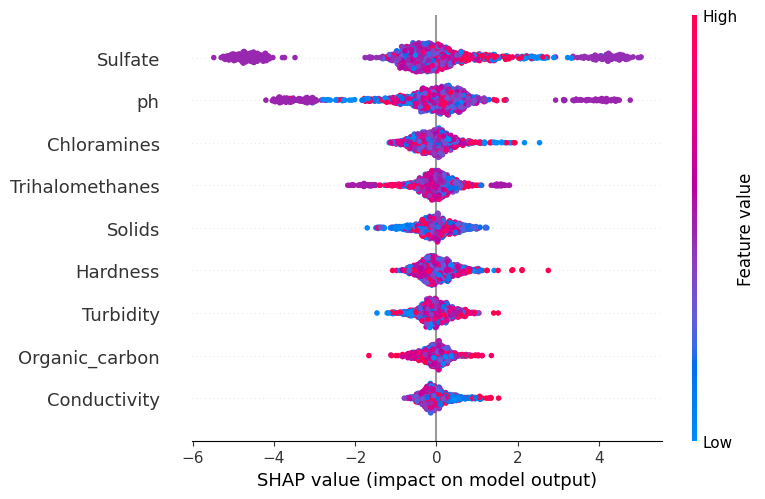

特徵排名:
           Feature   Importance
4          Sulfate  1537.761108
0               ph   983.161560
3      Chloramines   347.691345
7  Trihalomethanes   345.254150
2           Solids   333.570129
1         Hardness   304.054077
8        Turbidity   278.588531
6   Organic_carbon   240.798859
5     Conductivity   237.858810


In [6]:
# 使用SHAP解釋結果
# TreeExplainer為專門用於基於樹的模型（如 XGBoost)的解釋器
explainer = shap.TreeExplainer(model)
# shap_values為特徵對模型預測貢獻的數值
shap_values = explainer.shap_values(X_test)
# 生成 SHAP 值的可視化，展示哪些特徵對模型預測最為重要。
shap.summary_plot(shap_values, X_test)

# 特徵重要性排序
# 計算每個特徵的平均絕對 SHAP 值
mean_abs_shap_values = np.sum(np.abs(shap_values), axis=0)
# 建立特徵重要性表格
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': mean_abs_shap_values})
# 依據特徵重要性進行排序，sort_values(by='Importance')：根據 Importance 欄進行排序，ascending=False為醬序排列
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)


print("特徵排名:")
print(feature_importance)